In [1]:
import os.path as op
import os
# import sys
import numpy as np
import pandas as pd
import seaborn as sns
from fpdf import FPDF  

import mne
from mne.preprocessing import find_bad_channels_maxwell
import matplotlib.pyplot as plt
# from mne.time_frequency import psd_multitaper
from mne.preprocessing import annotate_muscle_zscore
from mne.preprocessing import ICA
from mne.preprocessing import read_ica
import scipy.stats


ModuleNotFoundError: No module named 'pandas'

In [2]:
pip install "mne[hdf5]"

     |████████████████████████████████| 7.4 MB 3.9 MB/s eta 0:00:01
     |████████████████████████████████| 38.6 MB 92.8 MB/s eta 0:00:01
     |████████████████████████████████| 11.6 MB 79.9 MB/s eta 0:00:01
     |████████████████████████████████| 18.2 MB 73.1 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 2.5 MB/s  eta 0:00:01
     |████████████████████████████████| 4.6 MB 89.1 MB/s eta 0:00:01
     |████████████████████████████████| 304 kB 66.0 MB/s eta 0:00:01
     |████████████████████████████████| 5.3 MB 87.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


## Preprocessing

In [7]:
# data_path =  'D:\projects\WM_GRID\DATA\mg99a'
# cal_path = 'D:\projects\WM_GRID\DATA\ctc'
# sss_path = 'D:\projects\WM_GRID\DATA\sss'

rawdir =  '/data/pt_02884/actspace/rawdir/'
out= '/data/pt_02884/actspace/'
cal_path = '/data/pt_02884/ctc'
sss_path = '/data/pt_02884/sss'
subject_id='as01'


Maxwellfilter

In [8]:
def viz_badch_scores(auto_scores, ch_type):
    fig, ax = plt.subplots(1, 4, figsize=(12, 8))
    fig.suptitle(f'Automated noisy/flat channel detection: {ch_type}',
                  fontsize=16, fontweight='bold')
    
    #### Noisy channels ####
    ch_subset = auto_scores['ch_types'] == ch_type
    ch_names = auto_scores['ch_names'][ch_subset]
    scores = auto_scores['scores_noisy'][ch_subset]
    limits = auto_scores['limits_noisy'][ch_subset]
    bins = auto_scores['bins']  #the windows that were evaluated
    
    # Label each segment by its start and stop time (3 digits / 1 ms precision)
    bin_labels = [f'{start:3.3f} – {stop:3.3f}' 
                  for start, stop in bins]
    
    # Store  data in DataFrame
    data_to_plot = pd.DataFrame(data=scores,
                                columns=pd.Index(bin_labels, name='Time (s)'),
                                index=pd.Index(ch_names, name='Channel'))
    
    # First, plot the raw scores
    sns.heatmap(data=data_to_plot, 
                cmap='Reds', 
                cbar=False,
                # cbar_kws=dict(label='Score'),
                ax=ax[0])
    [ax[0].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(bins))]
    ax[0].set_title('Noisy: All Scores', fontweight='bold')

    # Second, highlight segments that exceeded the 'noisy' limit
    sns.heatmap(data=data_to_plot,
                vmin=np.nanmin(limits),
                cmap='Reds', 
                cbar=True, 
                # cbar_kws=dict(label='Score'), 
                ax=ax[1])
    [ax[1].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(bins))]
    ax[1].set_title('Noisy: Scores > Limit', fontweight='bold')
    
    #### Flat channels ####
    ch_subset = auto_scores['ch_types'] == ch_type
    ch_names = auto_scores['ch_names'][ch_subset]
    scores = auto_scores['scores_flat'][ch_subset]
    limits = auto_scores['limits_flat'][ch_subset]
    bins = auto_scores['bins']  #the windows that were evaluated
    
    # Label each segment by its start and stop time (3 digits / 1 ms precision)
    bin_labels = [f'{start:3.3f} – {stop:3.3f}' 
                  for start, stop in bins]
    
    # Store  data in DataFrame
    data_to_plot = pd.DataFrame(data=scores,
                                columns=pd.Index(bin_labels, name='Time (s)'),
                                index=pd.Index(ch_names, name='Channel'))
    
    # First, plot the raw scores
    sns.heatmap(data=data_to_plot, 
                cmap='Reds', 
                cbar=False,
                # cbar_kws=dict(label='Score'),
                ax=ax[2])
    [ax[2].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(bins))]
    ax[2].set_title('Flat: All Scores', fontweight='bold')

    # Second, highlight segments that exceeded the 'noisy' limit
    sns.heatmap(data=data_to_plot,
                vmax=np.nanmax(limits),
                cmap='Reds', 
                cbar=True,
                # cbar_kws=dict(label='Score'), 
                ax=ax[3])
    [ax[3].axvline(x, ls='dashed', lw=0.25, dashes=(25, 15), color='gray')
        for x in range(1, len(bins))]
    ax[3].set_title('Flat: Scores > Limit', fontweight='bold')
    
    # Fit figure title to not overlap with the subplots
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    return fig

In [9]:
    data_path = os.path.join(rawdir,subject_id+'a')
    file_exts = ['%sa1']

    file_names = [f % (subject_id) for f in file_exts]

    # =============================================================================
    # GENERAL SETTINGS
    # =============================================================================

    # Set out_path folder or create it if it doesn't exist
    out_path = op.join(out, subject_id)
    if not op.exists(out_path):
        os.mkdir(out_path)

    # =============================================================================
    # MAXWELL FILTERING SETTINGS
    # =============================================================================

    # Set filtering method
    method='tsss'
    if method == 'tsss':
        st_duration = 10
    else:
        st_duration = None

In [10]:
    crosstalk_file = op.join(cal_path, "ct_sparse_leipzig_061201.fif")
    fine_cal_file = op.join(sss_path, "sss_cal_3029-Leipzig_140903.dat")

    # Create empty dataframe for bad channel list
    df = pd.DataFrame()
    
    # Prepare PDF report
    pdf = FPDF(orientation="P", unit="mm", format="A4")
    
    print("Processing subject: %s" % subject_id)
    run = 0
    for file_name in file_names:
        run = run + 1
        print("  File: %s" % file_name)
        
        # Read raw data
        raw_fname_in = op.join(data_path, file_name + '.fif')
        raw = mne.io.read_raw_fif(
            raw_fname_in,
            allow_maxshield=True,
            preload=False,
            verbose=True)
        
        # Detect bad channels
        raw.info['bads'] = ['MEG0712','MEG1241','MEG2641']
        raw_check = raw.copy()
        auto_noisy_chs, auto_flat_chs, auto_scores = find_bad_channels_maxwell(
            raw_check, 
            cross_talk=crosstalk_file, 
            calibration=fine_cal_file,
            return_scores=True,
            verbose=True)
        raw.info['bads'].extend(auto_noisy_chs + auto_flat_chs)
        
        # Append bad channels to the list 
        ''''''
        df = df.append({'run': run,
                        'noisy': auto_noisy_chs, 
                        'flat': auto_flat_chs},
                        ignore_index=True)        
        
        # Visualize the scoring used to classify channels as noisy or flat
        ch_type = 'grad'
        fig = viz_badch_scores(auto_scores, ch_type)
        fname_fig = op.join(out_path,
                            "01_r%s_badchannels_%sscore.png" % (run,ch_type))
        fig.savefig(fname_fig)
        plt.close()
        ch_type = 'mag'
        fig = viz_badch_scores(auto_scores, ch_type)
        fname_fig = op.join(out_path,
                            "01_r%s_badchannels_%sscore.png" % (run,ch_type))
        fig.savefig(fname_fig)
        plt.close()
        
        # Fix Elekta magnetometer coil types
        raw.fix_mag_coil_types()
        # realign
        file_name_ref=file_names[0]
        raw_ref_fname_in = op.join(data_path, file_name_ref + '.fif')
        raw_ref = mne.io.read_raw_fif(raw_ref_fname_in,
            allow_maxshield=True,
            preload=False,
            verbose=True)
        dev_head_t_ref = raw_ref.info['dev_head_t']
        raw_sss = mne.preprocessing.maxwell_filter(
            raw,
            origin='auto',
            cross_talk=crosstalk_file,
            calibration=fine_cal_file,
            st_duration=st_duration,
            coord_frame='head',
            destination=dev_head_t_ref,
            #coord_frame="meg", #only for empy room, comment it if using HPI
            verbose=True)
        
        # Show original and filtered power
        fig1 = raw.plot_psd(picks = ['meg'],fmin = 1,fmax = 100)
        fname_fig1 = op.join(out_path,
                            '01_r%s_plot_psd_raw100.png' % run)
        fig1.savefig(fname_fig1)
        plt.close()
        fig2 = raw_sss.plot_psd(picks = ['meg'],fmin = 1,fmax = 100)
        fname_fig2 = op.join(out_path,
                            '01_r%s_plot_psd_raw100%s.png' % (run,method))
        fig2.savefig(fname_fig2)
        plt.close()
        
        # Save filtered data
        fname_out = op.join(out_path,
                            file_name + '_' + method + '.fif')
        raw_sss.save(fname_out, overwrite=True)
        
    # Save bad channel list
    df.to_csv(op.join(out_path,
                      '01_raAll_meg_badch_list.csv'),
              index=False)

Processing subject: as01
  File: as01a1
Opening raw data file X:/pt_02884/actspace/rawdir/as01a\as01a1.fif...
    Read a total of 6 projection items:
        grad_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright2.fif : PCA-v3 (1 x 306)  idle
    Range : 26000 ... 906999 =     26.000 ...   906.999 secs
Ready.


C:\Users\peng\AppData\Local\Temp\3\ipykernel_18632\1639241876.py:18: RuntimeWarning: This filename (X:/pt_02884/actspace/rawdir/as01a\as01a1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(


Applying low-pass filter with 40.0 Hz cutoff frequency ...
Reading 0 ... 880999  =      0.000 ...   880.999 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    9.8s


Scanning for bad channels in 176 intervals (5.0 s) ...
102 of 102 magnetometer types replaced with T3.
    Bad MEG channels being reconstructed: ['MEG0712', 'MEG1241', 'MEG2641']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal_3029-Leipzig_140903.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 1.9°)
    Automatic origin fit: head of radius 94.2 mm
    Using origin 1.7, 11.1, 44.3 mm in the head frame
        Interval   1:    0.000 -    4.999
        Interval   2:    5.000 -    9.999
        Interval   3:   10.000 -   14.999
        Interval   4:   15.000 -   19.999
        Interval   5:   20.000 -   24.999
        Interval   6:   25.000 -   29.999
        Interval   7:   30.000 -   34.999
        Interval   8:   35.000 -   39.999
        Interval   9:   40.000 -   44.999
        Interval  10:   45.000 -   49.999
        Interval  11:   50.000 -   54.999
        Interval  12:   55.000 -

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
    data_path = os.path.join(rawdir,subject_id+'b')
    data_path_ref=os.path.join(rawdir,subject_id+'a')
    file_exts = ['%sb07',
                     '%sb08',
                     '%sb09',
                     '%sb10',
                     '%sb11',
                     '%sb12']

    file_names = [f % (subject_id) for f in file_exts]

    # =============================================================================
    # GENERAL SETTINGS
    # =============================================================================

    # Set out_path folder or create it if it doesn't exist
    out_path = op.join(out, subject_id)
    if not op.exists(out_path):
        os.mkdir(out_path)

    # =============================================================================
    # MAXWELL FILTERING SETTINGS
    # =============================================================================

    # Set filtering method
    method='tsss'
    if method == 'tsss':
        st_duration = 10
    else:
        st_duration = None

In [ ]:

    crosstalk_file = op.join(cal_path, "ct_sparse_leipzig_061201.fif")
    fine_cal_file = op.join(sss_path, "sss_cal_3029-Leipzig_140903.dat")

    # Create empty dataframe for bad channel list
    df = pd.DataFrame()
    
    # Prepare PDF report
    pdf = FPDF(orientation="P", unit="mm", format="A4")
    
    print("Processing subject: %s" % subject_id)
    run = 0
    for file_name in file_names:
        run = run + 1
        print("  File: %s" % file_name)
        
        # Read raw data
        raw_fname_in = op.join(data_path, file_name + '.fif')
        raw = mne.io.read_raw_fif(
            raw_fname_in,
            allow_maxshield=True,
            preload=False,
            verbose=True)
        
        # Detect bad channels
        raw.info['bads'] = ['MEG0712','MEG1241','MEG2641']
        raw_check = raw.copy()
        auto_noisy_chs, auto_flat_chs, auto_scores = find_bad_channels_maxwell(
            raw_check, 
            cross_talk=crosstalk_file, 
            calibration=fine_cal_file,
            return_scores=True,
            verbose=True)
        raw.info['bads'].extend(auto_noisy_chs + auto_flat_chs)
        
        # Append bad channels to the list 
        df = df.append({'run': run,
                        'noisy': auto_noisy_chs, 
                        'flat': auto_flat_chs},
                        ignore_index=True)        
        
        # Visualize the scoring used to classify channels as noisy or flat
        ch_type = 'grad'
        fig = viz_badch_scores(auto_scores, ch_type)
        fname_fig = op.join(out_path,
                            "01_rb%s_badchannels_%sscore.png" % (run,ch_type))
        fig.savefig(fname_fig)
        plt.close()
        ch_type = 'mag'
        fig = viz_badch_scores(auto_scores, ch_type)
        fname_fig = op.join(out_path,
                            "01_rb%s_badchannels_%sscore.png" % (run,ch_type))
        fig.savefig(fname_fig)
        plt.close()
        
        # Fix Elekta magnetometer coil types
        raw.fix_mag_coil_types()
        # realign
        # file_name_ref=file_names[0]
        file_name_ref=subject_id
        raw_ref_fname_in = op.join(data_path_ref, file_name_ref +'a01'+ '.fif')
        raw_ref = mne.io.read_raw_fif(raw_ref_fname_in,
            allow_maxshield=True,
            preload=False,
            verbose=True)
        dev_head_t_ref = raw_ref.info['dev_head_t']
        raw_sss = mne.preprocessing.maxwell_filter(
            raw,
            origin='auto',
            cross_talk=crosstalk_file,
            calibration=fine_cal_file,
            st_duration=st_duration,
            coord_frame='head',
            destination=dev_head_t_ref,
            #coord_frame="meg", #only for empy room, comment it if using HPI
            verbose=True)
        
        # Show original and filtered power
        fig1 = raw.plot_psd(picks = ['meg'],fmin = 1,fmax = 100)
        fname_fig1 = op.join(out_path,
                            '01_rb%s_plot_psd_raw100.png' % run)
        fig1.savefig(fname_fig1)
        plt.close()
        fig2 = raw_sss.plot_psd(picks = ['meg'],fmin = 1,fmax = 100)
        fname_fig2 = op.join(out_path,
                            '01_rb%s_plot_psd_raw100%s.png' % (run,method))
        fig2.savefig(fname_fig2)
        plt.close()
        
        # Save filtered data
        fname_out = op.join(out_path,
                            file_name + '_' + method + '.fif')
        raw_sss.save(fname_out, overwrite=True)
        
    # Save bad channel list
    df.to_csv(op.join(out_path,
                      '01_rbAll_meg_badch_list.csv'),
              index=False)

Artifact_annotation

In [ ]:
    out_path = op.join(out, subject_id)
    file_exts = ['%sa01',
                     '%sa02',
                     '%sa03',
                     '%sa04',
                     '%sa05',
                     '%sa06',
                     '%sb07',
                     '%sb08',
                     '%sb09',
                     '%sb10',
                     '%sb11',
                     '%sb12']

    file_names = [f % (subject_id) for f in file_exts]
    
    # The threshold is data dependent, check the optimal threshold by plotting
        # ``scores_muscle``.
    threshold_muscle = 10 # z-score
    
    print("Processing subject: %s" % subject_id)
    run = 0
    for file_name in file_names:
        run = run + 1
        print("  File: %s" % file_name)
        
        # Read raw data
        raw_fname_in = op.join(out_path,
                               file_name + '_tsss.fif')
        raw = mne.io.read_raw_fif(
            raw_fname_in, 
            preload=True, 
            verbose='error')
        
        # Create empty annotations list
        annot_artifact = mne.Annotations(onset=[], 
                                         duration=[],
                                         description=[])
        
        ###########################
        # Detect ocular artifacts #
        ###########################
        
        # Resetting the EOG channel
        
        ###########################
        # Detect muscle artifacts #
        ###########################
        
        # Notch filter
        raw_muscle = raw.copy().notch_filter([50, 100])
        
        # Choose one channel type, if there are axial gradiometers and magnetometers,
        # select magnetometers as they are more sensitive to muscle activity.
        annot_muscle, scores_muscle = annotate_muscle_zscore(
            raw_muscle, 
            ch_type="mag", 
            threshold=threshold_muscle, 
            min_length_good=0.2,
            filter_freq=[110, 140])
        
        # Add muscle artifacts to annotations list
        annot_artifact = annot_artifact + annot_muscle
        
        # Plot muscle z-scores across recording
        fig1, ax = plt.subplots()
        ax.plot(raw.times, scores_muscle)
        ax.axhline(y=threshold_muscle, color='r')
        ax.set(xlabel='time, (s)', ylabel='zscore', title='Muscle activity')
        fname_fig1 = op.join(out_path,
                            "02_r%s_artifact_muscle.png" % run)
        fig1.savefig(fname_fig1)
        plt.close()
    
        ###########################
        
        # Set annotations
        raw.set_annotations(annot_artifact)
        
        # View raw with annotations
        channel_picks = mne.pick_types(raw.info, 
                                       meg='mag', eog=True)
        fig2 = raw.plot(duration=50,
                       start=100,
                       order=channel_picks)
        fname_fig2 = op.join(out_path,
                            "02_r%s_artifact_annot.png" % run)
        fig2.savefig(fname_fig2)
        plt.close()
        
        
        # Save data with annotated artifacts
        fname_out = op.join(out_path,
                            file_name + '_artif.fif')                            
        raw.save(fname_out, overwrite=True)

In [ ]:
subject_id='mg15a'
out_path=op.join('/data/pt_02783/memory_grid/rawdir/',subject_id)
raw_fname_in=op.join(out_path,'mg15a06'+ '.fif')
raw=mne.io.read_raw_fif(raw_fname_in, preload=True, verbose='error')
%matplotlib qt
# raw.copy().filter(1,100).pick('mag').plot(duration=5,start=100)
# raw.copy().pick("MEG2511").plot(duration=5,start=100)


In [ ]:
raw.copy().filter(1,100).pick('mag').plot(duration=5,start=100)

In [ ]:
subject_id

In [ ]:
# %load 05-apply_ica.py
"""
===============
05. Apply ICA
===============

This relies on the ICAs computed in 05-run_ica.py

Open issues:
    1. Should we automitaze EOG- and ECG-related ICs detection?
    -> up to Ling and Oscar. Do auto and cross-check afterwards
    2. Add plots?
    -> no
    3. How many comps per type should we remove?
    -> 1-2 each (if any). 2-5 in total
    4. Apply on concatenated data? -> Yes
    
"""

def apply_ica(meg_ica_eog = [], meg_ica_ecg = []):
    # Prepare PDF report
    pdf = FPDF(orientation="P", unit="mm", format="A4")
    
    print("Processing subject: %s" % subject_id)
    run = 0
    for file_name in file_names:
        run = run + 1
        print("  File: %s" % file_name)
        
        # Read raw data
        raw_fname_in = op.join(out_path,
                               file_name + '_filter.fif')
        raw = mne.io.read_raw_fif(
            raw_fname_in, 
            preload=True, 
            verbose='error')
        
        # Show original signal

        chs = ['MEG0311', 'MEG0121', 'MEG1211', 'MEG1411']
        chan_idxs = [raw.ch_names.index(ch) for ch in chs]
        fig1 = raw.plot(order=chan_idxs,
                       duration=50,
                       start=100)        
        fname_fig1 = op.join(out_path,
                            '06_r%s_ica_raw0.png' % run)
        fig1.savefig(fname_fig1)
        plt.close()
        
        '''
        # Add figure to report
        pdf.add_page()
        pdf.set_font('helvetica', 'B', 16)
        pdf.cell(0, 10, file_name)
        pdf.ln(20)
        pdf.set_font('helvetica', 'B', 12)
        pdf.cell(0, 10, 'Timecourse of input data', 'B', ln=1)
        pdf.image(fname_fig1, 0, 45, pdf.epw)
        '''
        ###################
        # ICA on MEG data #
        ###################
        
        if [meg_ica_eog + meg_ica_ecg] != []:
            
            # Restore ICA solution from fif file
            ica_meg_fname = op.join(out_path,
                               subject_id + 'ALL-ica_meg.fif')
            ica_meg = read_ica(ica_meg_fname)
            
            # Select EOG- and ECG-related components for exclusion
            ica_meg.exclude.extend(meg_ica_eog + meg_ica_ecg)
            
            # # Plot excluded ICs
            # if meg_ica_eog != []:
            #     # Display component properties
            #     fig = ica.plot_properties(raw, 
            #                               picks=meg_ica_eog)
            #     for i in range(len(fig)):
            #         fname_fig = op.join(out_path, 
            #                             "04_r%s_ica_meg_eog%d.png" % (run,i))
            #         fig[i].savefig(fname_fig)
            #         plt.close(fig[i])
            # if meg_ica_ecg != []:
            #     # Display component properties
            #     fig = ica.plot_properties(raw, 
            #                               picks=meg_ica_ecg)
            #     for i in range(len(fig)):
            #         fname_fig = op.join(out_path, 
            #                             "04_r%s_ica_meg_ecg%d.png" % (run,i))
            #         fig[i].savefig(fname_fig)
            #         plt.close(fig[i])
            
        
        ###################
        
        # Remove selected components from the signal  #TODO: @Ling why "apply" is done in two different steps?
        raw_ica = raw.copy()
        ica_meg.apply(raw_ica)
        
        # Show cleaned signal
        fig_ica = raw_ica.plot(order=chan_idxs,
                               duration=50,
                               start=100)        
        fname_fig_ica = op.join(out_path,
                                '06_r%s_ica_rawICA.png' % run)
        fig_ica.savefig(fname_fig_ica)
        plt.close()
        
        '''
        # Add figures to report
        pdf.ln(120)
        pdf.cell(0, 10, 'Timecourse of output data', 'B', ln=1)
        pdf.image(fname_fig_ica, 0, 175, pdf.epw)
        '''
        # Save cleaned raw data
        fname_out = op.join(out_path,
                            file_name + '_ica.fif')
        raw_ica.save(fname_out,overwrite=True)
    
    # Save report  #TODO: add note about removed ICs
    # pdf.output(op.join(out_path,
    #                   'apply_ica' + '-report.pdf'))
    
    # sys.stdout.close()      # close log file
    # sys.stdout = stdout_obj # restore command prompt




In [ ]:
    data_path = os.path.join(rawdir,subject_id)
    file_exts = ['%sa01',
                     '%sa02',
                     '%sa03',
                     '%sa04',
                     '%sa05',
                     '%sa06',
                     '%sb07',
                     '%sb08',
                     '%sb09',
                     '%sb10',
                     '%sb11',
                     '%sb12']

    file_names = [f % (subject_id) for f in file_exts]
    meg_ica_eog = [1]
    meg_ica_ecg = [5]
    apply_ica(meg_ica_eog = meg_ica_eog,
                meg_ica_ecg = meg_ica_ecg)

In [ ]:

# sss_path = '/data/pt_02783/sss'
rawdir =  '/data/pt_02774/memory_grid/'

subject_id = 'mg15'
data_path = os.path.join(rawdir,subject_id)
file_name = (subject_id+"a01")
fname_epo = op.join(data_path,
                            file_name + 'ALL_epo_rsample.fif')
epochs =  mne.read_epochs(fname_epo,
                          preload = True,
                          verbose = True)

In [3]:
# sss_path = '/data/pt_02783/sss'
rawdir =  '/data/pt_02774/memory_grid/'

subject_id = 'mg15'
data_path = os.path.join(rawdir,subject_id)
file_name = (subject_id)
fname_epo = op.join(data_path,
                            file_name + 'ALL_epo_rsample_reject.fif')
epochs =  mne.read_epochs(fname_epo,
                          preload = True,
                          verbose = True)

Reading /data/pt_02774/memory_grid/mg15/mg15ALL_epo_rsample_reject.fif ...


/tmp/ipykernel_221946/1903508699.py:9: RuntimeWarning: This filename (/data/pt_02774/memory_grid/mg15/mg15ALL_epo_rsample_reject.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs =  mne.read_epochs(fname_epo,


    Found the data of interest:
        t =    -500.00 ...    8195.00 ms
        0 CTF compensation matrices available
Not setting metadata
718 matching events found
No baseline correction applied
0 projection items activated


In [5]:
epochs['bad'].info

KeyError: 'Event name "bad" could not be found. The following events are present in the data: 101'

In [ ]:
%matplotlib qt
epochs.plot(group_by="selection",
             butterfly=True)

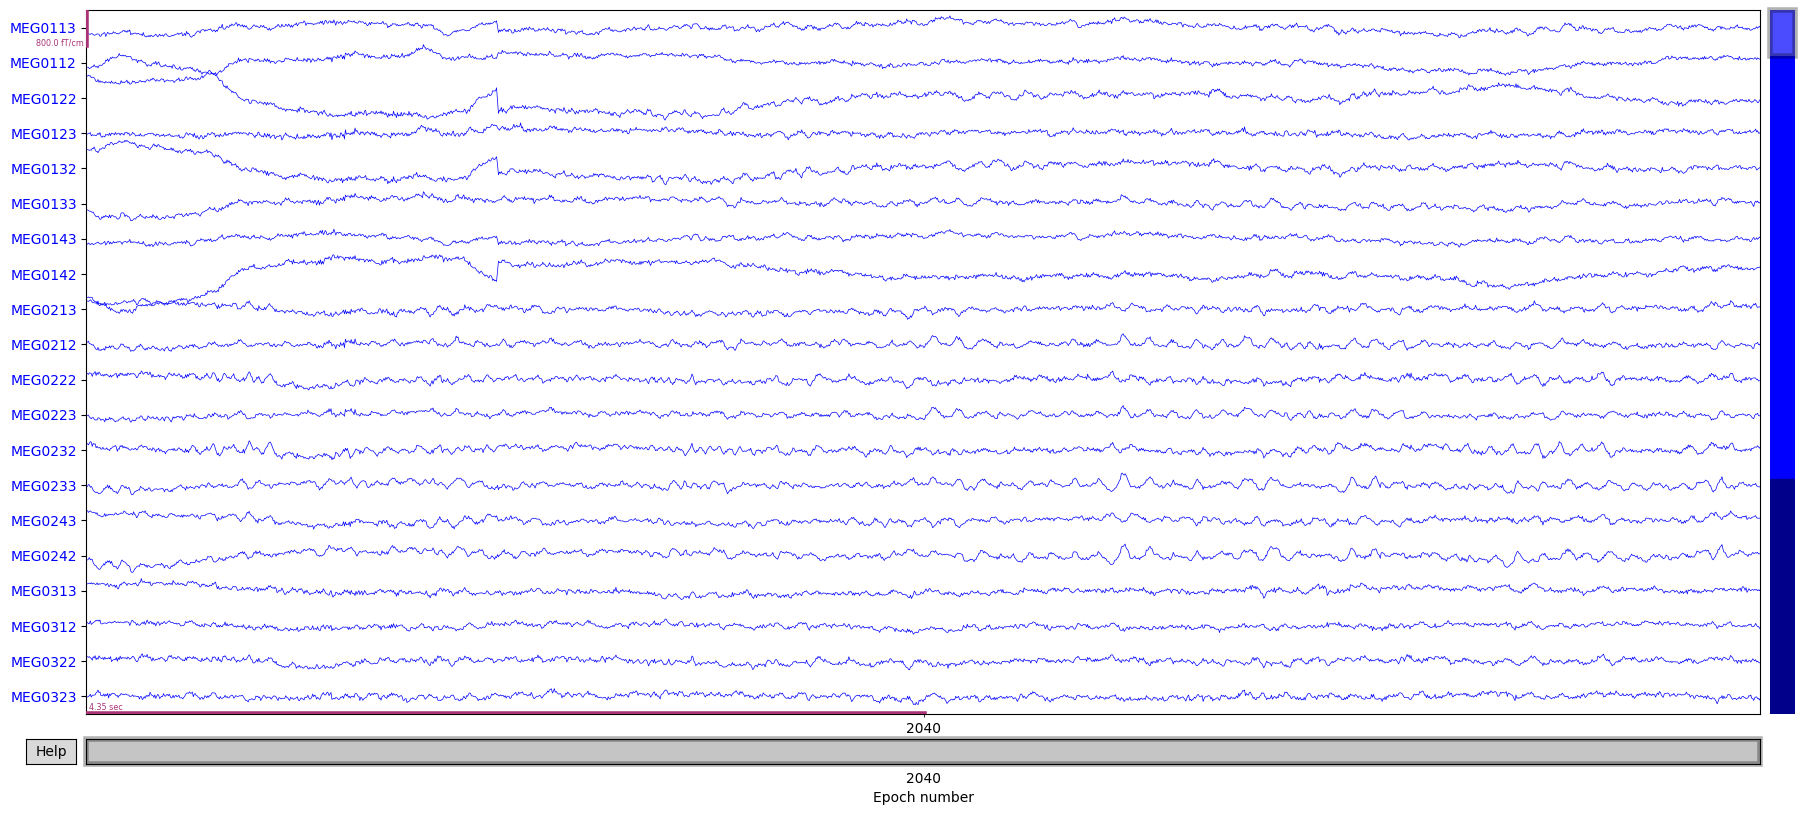

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


Traceback (most recent call last):
  File "/data/pt_02783/projects/WM_GRID/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py", line 304, in process
    func(*args, **kwargs)
  File "/data/pt_02783/projects/WM_GRID/venv/lib/python3.10/site-packages/mne/viz/_mpl_figure.py", line 276, in _close
    self.mne.parent_fig.mne.child_figs.remove(self)
ValueError: list.remove(x): x not in list


In [6]:
epochs[340].plot()

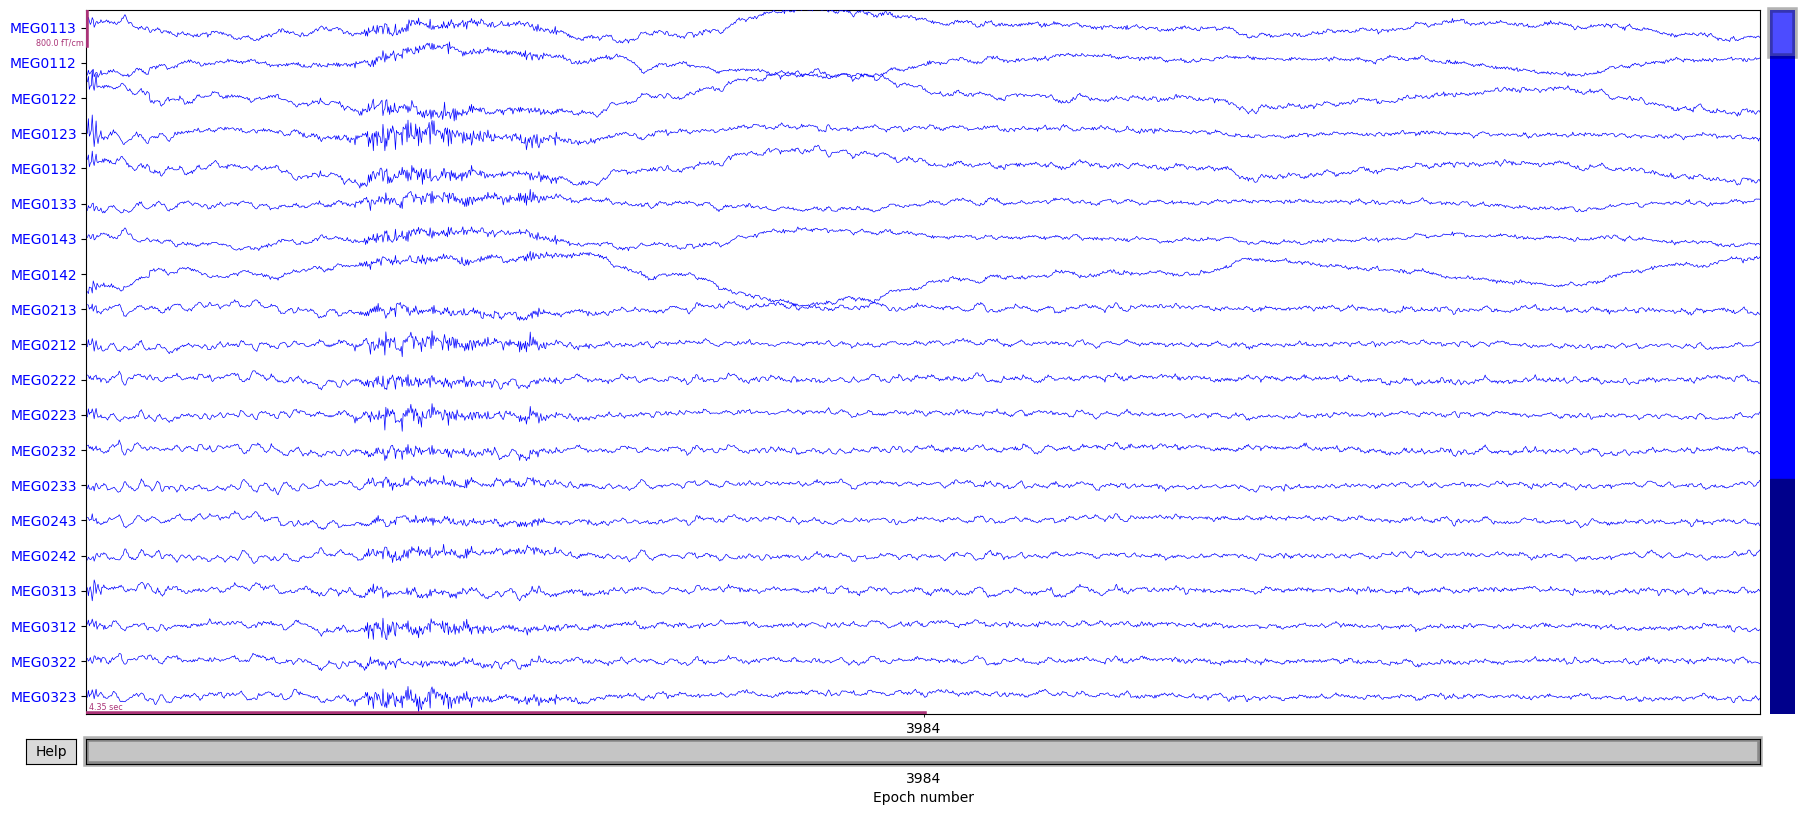

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [7]:
epochs[664].plot()

In [8]:
epochs.drop([340,664],reason='USER',verbose=None)
file_name = (subject_id)
epochs.save(op.join(data_path,
                    file_name + 'ALL_epo_rsample_reject.fif'),                           
                    overwrite=True)

Dropped 2 epochs: 340, 664


/tmp/ipykernel_26113/669246752.py:3: RuntimeWarning: This filename (/data/pt_02774/memory_grid/mg15/mg15ALL_epo_rsample_reject.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(op.join(data_path,
